# QSGA Whitepaper 4 - Laplacian Hamiltonians Perturbation Method 

Ohad Lev

October-November 2025

------

In [4]:
import numpy as np
import networkx as nx
import matplotlib.pyplot as plt

from qiskit.quantum_info import SparsePauliOp
from qiskit.visualization import array_to_latex

from qsga.hamiltonian_generators import (
    obtain_skeleton_laplacian,
    obtain_random_m_local_perturbation,
    obtain_random_perturbed_laplacian
)
from qsga.data_verifiers import is_valid_laplacian

---------

## What do we want?

Given an $IX_n$ Laplacian Hamiltonian $\mathbf{L} \in \mathbb{R}^{2^n \times 2^n}$, our goal is to *perturbate* $\mathbf{L}$ in $\mathrm{poly}(n) = \mathrm{polylog}(|V|)$ steps (= efficiently), such that the resulting (weighted) *perturbated Laplacian Hamiltonian* $\mathbf{L}' \in \mathbb{R}^{2^n \times 2^n}$, has a non-trivial spectrum.

## How shall we do it?

It is possible to manipulate any entry in a matrix by means of the Pauli basis, where the building blocks for such manipulations are the following matrices:

$$
    |0\rangle\langle0| = \begin{bmatrix}
        1 & 0 \\
        0 & 0
    \end{bmatrix} = \frac{1}{2}(\mathbf{I} + \mathbf{Z}) \quad
    |0\rangle\langle1| = \begin{bmatrix}
        0 & 1 \\
        0 & 0
    \end{bmatrix} = \frac{1}{2}(\mathbf{X} + i\mathbf{Y}) \\
    |1\rangle\langle0| = \begin{bmatrix}
        0 & 0 \\
        1 & 0
    \end{bmatrix} = \frac{1}{2}(\mathbf{X} - i\mathbf{Y}) \quad
    |1\rangle\langle1| = \begin{bmatrix}
        0 & 0 \\
        0 & 1
    \end{bmatrix} = \frac{1}{2}(\mathbf{I} - \mathbf{Z})
    \tag{1}
$$

It is evident that $\big\{|0\rangle\langle0|, |1\rangle\langle0|, |0\rangle\langle1|, |1\rangle\langle1|\big\}$ is a basis for the space of all $2 \times 2$ matrices, $\mathbb{C}^{2 \times 2}$. The generalzation for a basis for any $2^n \times 2^n$ matrices is straightforward:

$$
    \mathbb{C}^{2^n\times2^n} = \mathrm{span}\bigl\{
        |i\rangle\langle j|
        \;\big|\;
        i,j \in \{0,1\}^n
    \bigr\}
    \tag{2}
$$

We demonstrate with the case of $n = 2$ to make things clear:

$$
    \begin{bmatrix}
        |00\rangle\langle00| & |00\rangle\langle01| & |00\rangle\langle10| & |00\rangle\langle11| \\[4pt]
        |01\rangle\langle00| & |01\rangle\langle01| & |01\rangle\langle10| & |01\rangle\langle11| \\[4pt]
        |10\rangle\langle00| & |10\rangle\langle01| & |10\rangle\langle10| & |10\rangle\langle11| \\[4pt]
        |11\rangle\langle00| & |11\rangle\langle01| & |11\rangle\langle10| & |11\rangle\langle11|
    \end{bmatrix}
    \tag{3}
$$

Each entry outer-product $|i\rangle\langle j|$ is a distinct rank-one matrix in $\mathbb{C}^{4\times4}$,
forming the complete operator basis for the two-qubit Hilbert space spanned by $\big\{|00\rangle, |01\rangle, |10\rangle, |11\rangle \big\}$.

The method of computing every such outer-product is also straightforward, and it works bit-by-bit using the building blocks presented in equation $(1)$:

$$
    |i\rangle\langle j| = \bigotimes_{k = 0}^{n - 1} |i_k\rangle\langle j_k|
    \tag{4}
$$

For example:

$$
    |001\rangle \langle 101| = |0\rangle\langle1| \otimes
    |0\rangle\langle0| \otimes
    |1\rangle\langle1|
    \tag{5}
$$

So, in priniciple, we can add any edge we want to the Laplacian Hamiltonian by manipulating entries as needed, and here are our perturbations. The question is - can we do it efficiently?

The computation of each entry involves an $m$-dimensional Kronecker product, where $m$ is the dimension of the outer-product, which is good (efficient). However, we should carefully notice that the number of Pauli strings required to manifest each entry using this method is $2^m$, which is bad (exponential cost).

TODO:?To create an edge we need to manipulate multiple entries ($4$), and it is also often that Pauli strings cancel with each other in that case, so it might be the case that a perturbation constructed from $4$ entries costs less

Hence, what we decided to do is to *inject* a constant (or $\mathrm{poly}(n)$? TODO) number of $m$-local perturbations to the Laplacian Hamiltonian, where each such $m$-local perturbation is scaled by the identity operator to the dimensions of the global Laplacian Hamiltonian. For each such $m$-local perturbation implementation we compute $4$ entries, where each entry consists of $2^m$ Pauli strings. So one might think that the exact Pauli string cost of each perturbation implementation is $4 \cdot 2^m$, however (luckily) in many cases further simplifcation is possible, so what we can conclude is that the complexity of generating each perturbation is $\Theta(2^m)$. Here is an example of an unscaled $2$-local random perturbation:

In [5]:
P = obtain_random_m_local_perturbation(m=2, simplify=False)
P_list = P.to_list()

print(f"The unsimiplified perturbation Hamitlonian consists of {len(P_list)} Paulis is:")
print(P_list)
print()

display(array_to_latex(P, prefix=r"\mathbf{P} = \tag{6}"))

The unsimiplified perturbation Hamitlonian consists of 17 Paulis is:
[('II', 0j), ('II', (0.25+0j)), ('IZ', (-0.25+0j)), ('ZI', (-0.25+0j)), ('ZZ', (0.25+0j)), ('XX', (-0.25+0j)), ('XY', (-0-0.25j)), ('YX', (-0-0.25j)), ('YY', (0.25-0j)), ('XX', (-0.25+0j)), ('XY', 0.25j), ('YX', 0.25j), ('YY', (0.25+0j)), ('II', (0.25+0j)), ('IZ', (0.25+0j)), ('ZI', (0.25+0j)), ('ZZ', (0.25+0j))]



<IPython.core.display.Latex object>

And after simplification:

In [6]:
P_simplified = P.simplify()
P_simplified_list = P_simplified.to_list()

print(f"The simiplified perturbation Hamitlonian consists of {len(P_simplified_list)} Paulis is:")
print(P_simplified_list)
print()

display(array_to_latex(P_simplified, prefix=r"\mathbf{P} = \tag{7}"))

The simiplified perturbation Hamitlonian consists of 4 Paulis is:
[('II', (0.5+0j)), ('ZZ', (0.5+0j)), ('XX', (-0.5+0j)), ('YY', (0.5+0j))]



<IPython.core.display.Latex object>

It can be seen that the meaning of this unscaled perturbation $\mathbf{P}$ is adding a single (local) edge between two nodes. The next step is to scale the perturbation to the dimensions of the Laplacian Hamiltonian, as follows:

$$
    \mathbf{P}_{\text{scaled}} = \mathbf{I}^{\otimes (n - m)} \otimes \mathbf{P}
    \tag{8}
$$

So for our case, when e.g. $n = 4$:

In [7]:
P_scaled = SparsePauliOp("II").tensor(P)
display(
    array_to_latex(P_scaled, max_size=16, prefix=r"\mathbf{P}_{\text{scaled}} = \tag{9}")
)

is_valid_laplacian(P_scaled.to_matrix().real, is_weigthed=False)

<IPython.core.display.Latex object>

The matrix is a valid (unweighted) Laplacian matrix


True

One might also consider a slight modification of the scaling method:

$$
    \mathbf{P}_{\text{random_scaled}} =
    \mathbf{I}^{\otimes t} \otimes
    \mathbf{P} \otimes
    \mathbf{I}^{\otimes (n - m - t)},
    \quad
    t \sim \mathrm{Uniform}\{0, 1, \dots, n - m\}.
    \tag{10}
$$

For example, we take the same perturbation above and instead of scaling with $\mathbf{I \otimes I \otimes P}$, we use $\mathbf{I \otimes P \otimes I}$:

In [8]:
P_rscaled = SparsePauliOp("I").tensor(P).tensor(SparsePauliOp("I"))
display(
    array_to_latex(P_rscaled, max_size=16, prefix=r"\mathbf{P}_{\text{random_scaled}} = \tag{10}")
)

is_valid_laplacian(P_rscaled.to_matrix().real, is_weigthed=False)

<IPython.core.display.Latex object>

The matrix is a valid (unweighted) Laplacian matrix


True

And we see that the scaling is different, leading to more global spreading of the scaled perturbations, but the resulting matrices are still valid Laplacian matrices.

## Algorithm Formulation

* **Input:**
    * An $IX_n$ graph Laplacian Hamiltonian $\mathbf{L}$ - in a sparse Pauli representation.
    * Number of desired pertubations $n_p$.
    * Maximum pertubation locality $l_p$.


* **Output** - a pertubated Laplacin Hamiltonian $L_p$ (in a sparse Pauli representation), such that:
    * It is a mix of $\mathbf{L}$ with $n_p$ scaled local pertubations.
    * Each pertubation $\mathbf{P}_i$ is $m_i$-local, where $m_i \sim \mathrm{Uniform}\{1, \dots, l_p \}$.
    

* **Algorithm**:
    * TODO.        

## Demonstration

### Small setting

In [9]:
N_NUM_QUBITS = 4
D_SKELETON_REGULARITY = 3
MAX_SKELETON_LOCALITY = 2
NUM_PERTUBATIONS = 3
MAX_PERTUBATION_DIM = 2

NUM_NODES = 2 ** N_NUM_QUBITS

In [13]:
L1 = obtain_skeleton_laplacian(
    n=N_NUM_QUBITS,
    d=D_SKELETON_REGULARITY,
    max_locality=MAX_SKELETON_LOCALITY,
)

L1_p = obtain_random_perturbed_laplacian(
    skeleton_hamiltonian=L1,
    num_perturbations=NUM_PERTUBATIONS,
    max_perturbation_locality=MAX_PERTUBATION_DIM,
)

L1_pr = obtain_random_perturbed_laplacian(
    skeleton_hamiltonian=L1,
    num_perturbations=NUM_PERTUBATIONS,
    max_perturbation_locality=MAX_PERTUBATION_DIM,
    random_perturbations_scaling=True
)

L1_pw = obtain_random_perturbed_laplacian(
    skeleton_hamiltonian=L1,
    num_perturbations=NUM_PERTUBATIONS,
    max_perturbation_locality=MAX_PERTUBATION_DIM,
)

L1_pwr = obtain_random_perturbed_laplacian(
    skeleton_hamiltonian=L1,
    num_perturbations=NUM_PERTUBATIONS,
    max_perturbation_locality=MAX_PERTUBATION_DIM,
    random_perturbations_scaling=True
)

is_valid_laplacian(L1)
is_valid_laplacian(L1_p)
is_valid_laplacian(L1_pr)
is_valid_laplacian(L1_pw)
is_valid_laplacian(L1_pwr)

The matrix is a valid (weighted) Laplacian matrix
The matrix is a valid (weighted) Laplacian matrix
The matrix is a valid (weighted) Laplacian matrix
The matrix is a valid (weighted) Laplacian matrix
The matrix is a valid (weighted) Laplacian matrix


True

### Large setting

In [14]:
N_NUM_QUBITS = 11
D_SKELETON_REGULARITY = 13
MAX_SKELETON_LOCALITY = 3
NUM_PERTUBATIONS = 9
MAX_PERTUBATION_DIM = 5

NUM_NODES = 2 ** N_NUM_QUBITS

In [15]:
L2 = obtain_skeleton_laplacian(
    n=N_NUM_QUBITS,
    d=D_SKELETON_REGULARITY,
    max_locality=MAX_SKELETON_LOCALITY,
)

L2_p = obtain_random_perturbed_laplacian(
    skeleton_hamiltonian=L2,
    num_perturbations=NUM_PERTUBATIONS,
    max_perturbation_locality=MAX_PERTUBATION_DIM,
)

L2_pr = obtain_random_perturbed_laplacian(
    skeleton_hamiltonian=L2,
    num_perturbations=NUM_PERTUBATIONS,
    max_perturbation_locality=MAX_PERTUBATION_DIM,
)

L2_pw = obtain_random_perturbed_laplacian(
    skeleton_hamiltonian=L2,
    num_perturbations=NUM_PERTUBATIONS,
    max_perturbation_locality=MAX_PERTUBATION_DIM,
)

L2_pwr = obtain_random_perturbed_laplacian(
    skeleton_hamiltonian=L2,
    num_perturbations=NUM_PERTUBATIONS,
    max_perturbation_locality=MAX_PERTUBATION_DIM,
    random_perturbations_scaling=True
)

is_valid_laplacian(L2)
is_valid_laplacian(L2_p)
is_valid_laplacian(L2_pr)
is_valid_laplacian(L2_pw)
is_valid_laplacian(L2_pwr)

L2_spectrum = np.linalg.eigvalsh(L2)
L2_p_spectrum = np.linalg.eigvalsh(L2_p)
L2_pr_spectrum = np.linalg.eigvalsh(L2_pr)
L2_pw_spectrum = np.linalg.eigvalsh(L2_pw)
L2_pwr_spectrum = np.linalg.eigvalsh(L2_pwr)

The matrix is a valid (weighted) Laplacian matrix
The matrix is a valid (weighted) Laplacian matrix
The matrix is a valid (weighted) Laplacian matrix
The matrix is a valid (weighted) Laplacian matrix
The matrix is a valid (weighted) Laplacian matrix


In [16]:
import networkx as nx
import numpy as np

# parameters
p = 0.0055         # probability of edge creation
weight_range = (0.5, 3.0)  # weight range

# create random Erdos–Renyi graph
G = nx.erdos_renyi_graph(NUM_NODES, p)

# assign random weights to edges
for (u, v) in G.edges():
    G[u][v]['weight'] = np.random.uniform(*weight_range)

# show some info
# print(nx.info(G))
print("Example edge weights:")
for u, v, d in list(G.edges(data=True))[:5]:
    print(f"{u}-{v}: {d['weight']:.3f}")
    
random_graph_spectrum = np.linalg.eigvalsh(nx.laplacian_matrix(G).toarray())

Example edge weights:
0-54: 1.883
0-149: 1.514
0-214: 2.123
0-694: 2.183
0-770: 2.744


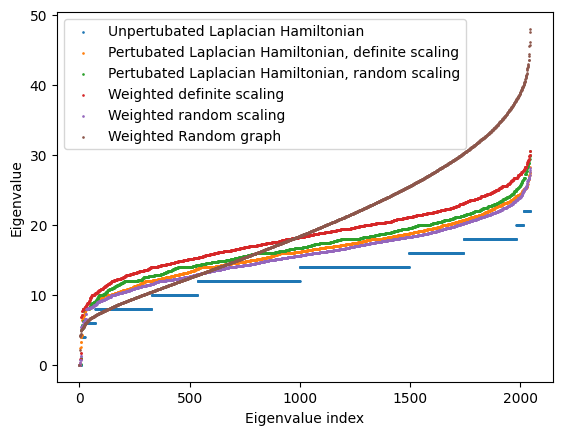

In [17]:
NODES = range(NUM_NODES)

scatter_size = 0.8

plt.scatter(NODES, L2_spectrum, s=scatter_size, label="Unpertubated Laplacian Hamiltonian")
plt.scatter(NODES, L2_p_spectrum, s=scatter_size, label="Pertubated Laplacian Hamiltonian, definite scaling")
plt.scatter(NODES, L2_pr_spectrum, s=scatter_size, label="Pertubated Laplacian Hamiltonian, random scaling")
plt.scatter(NODES, L2_pw_spectrum, s=scatter_size, label="Weighted definite scaling")
plt.scatter(NODES, L2_pwr_spectrum, s=scatter_size, label="Weighted random scaling")
plt.scatter(NODES, random_graph_spectrum, s=scatter_size, label="Weighted Random graph")

plt.xlabel("Eigenvalue index")
plt.ylabel("Eigenvalue")

plt.legend()
plt.show()